# Introduction

# Methodology

3-stage process:

1. High-level overview
    - Descriptive statistics using Pandas Profiling to get general sense of variables
2. Data preparation
    - Data processing and feature engineering based on initial findings
    - BERT vectors and density-based clustering
3. Sensemaking
    - EDA focused on `name`
4. Summary of results

# 0. Setup

In [1]:
import os
import joblib

# Data analysis
import numpy as np
import pandas as pd
from pandas_profiling import profile_report
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stats

# Vectorization & clustering
from sklearn.metrics.pairwise import cosine_similarity

# Data viz
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
data_path = os.path.abspath("../../data")
df = pd.read_csv(data_path + "/companies_sorted.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173426 entries, 0 to 7173425
Data columns (total 11 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   Unnamed: 0                 int64  
 1   name                       object 
 2   domain                     object 
 3   year founded               float64
 4   industry                   object 
 5   size range                 object 
 6   locality                   object 
 7   country                    object 
 8   linkedin url               object 
 9   current employee estimate  int64  
 10  total employee estimate    int64  
dtypes: float64(1), int64(3), object(7)
memory usage: 602.0+ MB


# 1. High-level overview

### Descriptive statistics (using PandasProfiling)

Since it is a fairly large dataset (over 7M rows consuming over 600 MB in memory), we will configure Pandas Profiling to decrease the computational overhead while still keeping meaningful information from our data. This entails the following actions:

- Take a random sample of 20% of the original dataset ($N_\mathrm{sample} = 1,434,685$) and use this dataset to generate the profile.
- Set the attribute `minimal` to `True`.

In [3]:
sample_df = df.sample(frac=0.2)
eda_profile = sample_df.profile_report(minimal=True)
output_dir = os.path.abspath("../../reports")
eda_profile.to_file(output_file=output_dir + "/eda_profile.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
eda_profile

## Summary of descriptive statistics

### Categorical variables
**year founded**
* The distribution skews towards the 2000s range, with year 2009 representing the median value. 
* About half of the data is missing for this field.
* There are visible outliers at both tails of the distribution (e.g., 1451 on the lower end, and all years above 2022 on the higher end).

**industry**
* The following industries make up for 22.7% of the total industries reported: Information Technology and Services, Marketing and Advertising, Construction, Real Estate, Management Consulting, and Computer Software.
* The variable has high cardinality (less than 0.1% distinct values).
* Around 4% of values are missing.

**size range**
* About 78% of businesses have 1-10 staff/employees and 98% have at most 500 staff/employees.

**country**
* About 32% of businesses are located in the United States, followed by 7.2% in the United Kingdom.
* About 32% of business don't have a country associated with them

**locality**
* About 35% of values are missing.
* There's high cardinality in the data with over 53,000 unique values.

### Numerical variables

**estimated company employees**
* About 20% of values are 0 and 34% of values are 1.
* Highly skewed towards 0.

**total company employees**
* Over 36% of values are 1 and 15% are 2.
* Highly skewed towards 1.

### Text fields
**linkedin url**
* All companies have a Linkedin account.

**domains**
* About 23% of data is missing.

**name**
* All companies have a name registered.
* There are some repeated values (about 0.1%), particularly for those cases in which the name was used to describe the profession or type of company (e.g., "independent consultant", or "law firm"). 

## Data processing steps based on these findings

**Unnamed: 0**
* Drop column as it doesn't seem to contain meaningful information.

**year founded**
* Remove rows with outlier values (e.g., 1850 <= year <= 2022).
* Change data type to integer.

**industry**
* Perform clustering to consolidate industry categories based on similarity (lowering cardinality).

**locality**
* Standardize lexical composition (i.e., all lower case).
* Separate values into unique fields (city, state, country).

**current employee estimate**
* Remove column as over 20% of values are 0, and use data from `total employee estimate` instead.

**domains**
* Extract domain type and fill new field with those values.

**name**
* Remove duplicate values that don't seem to relate to a business name.
* Encode values into BERT vectors to compute similarities between data points.
* Compute corpus linguistics.

**linkedin url**
* Remove reduntant portion of string (e.g., 'linkedin.com/company/').
* Detect languages and fill new field with those values.

# 2. Data preparation

## Data processing

In [5]:
artifacts_path = os.path.abspath("../../artifacts")
cleaned_df = pd.read_pickle(os.path.join(artifacts_path, "cleaned_df.pkl"))
print(f"Original dataset length: {len(df)}, cleaned dataset length: {len(cleaned_df)}")

Original dataset length: 7173426, cleaned dataset length: 3489398


## Feature engineering

In [6]:
feat_eng_df = pd.read_pickle(os.path.join(artifacts_path, "feat_eng_df.pkl"))
feat_eng_df.head()

,Unnamed: 0,name,domain,year founded,industry,size range,locality,country,linkedin url,total employee estimate,domain_type,state,city,lang
0,5872184,ibm,ibm.com,1911.0,information technology and services,10001+,"new york, new york, united states",united states,ibm,716906,com,new york,new york,en
1,4425416,tata consultancy services,tcs.com,1968.0,information technology and services,10001+,"bombay, maharashtra, india",india,tata-consultancy-services,341369,com,maharashtra,bombay,en
2,21074,accenture,accenture.com,1989.0,information technology and services,10001+,"dublin, dublin, ireland",ireland,accenture,455768,com,dublin,dublin,en
4,1558607,ey,ey.com,1989.0,accounting,10001+,"london, greater london, united kingdom",united kingdom,ernstandyoung,428960,com,greater london,london,en
5,3844889,hewlett-packard,hpe.com,1939.0,information technology and services,10001+,"palo alto, california, united states",united states,hewlett-packard-enterprise,412952,com,california,palo alto,en


> Note: The feature engineering process missed assigning the right data type to the column `year founded` and eliminating column `Unnamed:0`, so I will do so now.

In [7]:
feat_eng_df["year founded"].fillna(0, inplace=True)
feat_eng_df["year founded"] = feat_eng_df["year founded"].astype("int64")
feat_eng_df = feat_eng_df.drop("Unnamed: 0", axis=1)

## Vectorization + Clustering

In [8]:
# BERT vectors
vectors_b1 = pd.read_pickle(artifacts_path + "/vectors_b1.pkl")
vectors_b1.head()

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
5370658,0.380186,0.234769,-0.278346,-0.011218,-0.032884,-0.231501,0.240049,0.085648,-0.505654,-0.283640,...,0.266764,0.045364,0.032722,0.135081,-0.006203,-0.529444,-0.344539,-0.104402,-0.071330,0.155056
5062632,0.238551,0.062065,-0.376870,-0.147968,0.005066,-0.112608,0.272549,0.018531,-0.427823,-0.202860,...,0.295696,0.071479,-0.066314,0.097786,0.122660,-0.411575,-0.244819,-0.167024,-0.006162,0.204691
4503786,0.450677,0.410961,-0.214999,-0.169736,0.142792,-0.231919,0.370349,-0.276896,-0.525932,-0.259666,...,0.408841,-0.063791,-0.144642,0.069462,0.156923,-0.442572,-0.540361,-0.356442,0.093795,0.112478
6611753,0.292872,0.199054,-0.275169,-0.038527,-0.009881,-0.258502,0.312343,0.041925,-0.474687,-0.366438,...,0.241582,-0.009510,0.129520,0.264398,-0.080313,-0.461918,-0.252048,-0.167785,0.008586,0.217574
6150185,0.345533,0.095073,-0.275633,-0.115940,0.022746,-0.168768,0.183908,-0.136030,-0.461607,-0.127874,...,0.251011,0.062451,-0.079031,0.202081,0.245795,-0.371174,-0.264082,-0.180675,0.035028,0.199559


In [9]:
# Density-based clusters
model = joblib.load(os.path.join(artifacts_path, "optics.joblib"))
cluster_df = pd.DataFrame(model, columns=["cluster"], index=vectors_b1.index)
cluster_df.head()

,cluster
5370658,-1
5062632,-1
4503786,-1
6611753,-1
6150185,-1


## Corpus linguistics

In [10]:
corpus_df = pd.read_pickle(os.path.join(artifacts_path, "corpus_stats.pkl"))
corpus_df.head()

,name,has_stopwords,lexical_density,has_digits,has_special_chars
0,ibm,False,1.000,False,False
1,tata consultancy services,False,1.000,False,False
2,accenture,False,1.000,False,False
4,ey,False,0.000,False,False
5,hewlett-packard,False,0.667,False,True


# 3. Sensemaking

## Business names clusters

In [11]:
cluster_df.value_counts(normalize=True)[:10]

cluster
-1         0.970268
 29        0.002221
 2         0.001791
 28        0.001433
 19        0.001361
 7         0.001361
 15        0.001218
 11        0.001003
 30        0.001003
 21        0.000931
dtype: float64

* Majority of data points failed to make it to a cluster. We will ignore these for now for the purposes of this analysis.

<AxesSubplot:title={'center':'Total clusters (N=13958)'}, xlabel='cluster'>

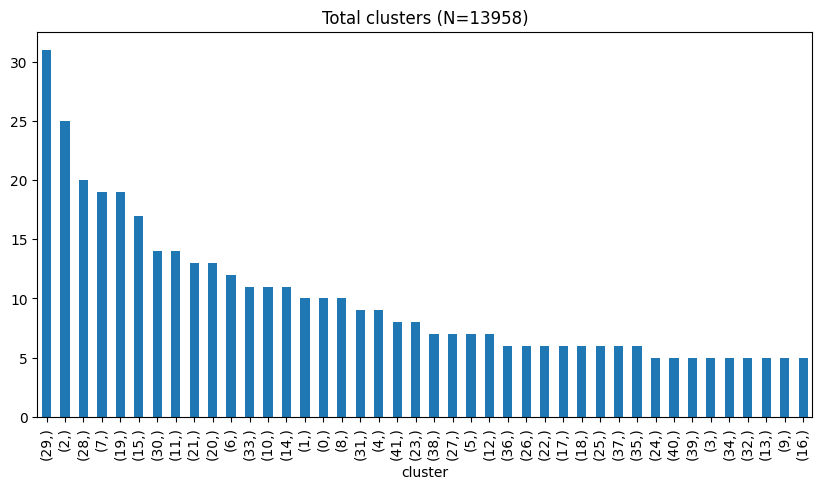

In [12]:
cluster_df.query("cluster != -1").value_counts().plot(
    kind="bar", 
    figsize=(10, 5), 
    title=f"Total clusters (N={len(vectors_b1)})"
)

* Using a subset of the data ($N=13958$), we can get a sense of how business names can be clustered together based on their vector representations.
* Let's print five examples of the top 10 clusters:

In [13]:
cluster_idx_list = cluster_df.query("cluster != -1").value_counts().index.tolist()
for n, idx in enumerate(cluster_idx_list):
    i = idx[0]
    top_5 = df.iloc[cluster_df.query("cluster == @i").index.tolist()]["name"].values.tolist()[:5]
    print(f"Cluster {i}:")
    for name in top_5:
        print(name)
    print()
    if n == 10:
        break

Cluster 29:
thinkinno technologies pvt. ltd.
harsh constructions pvt. ltd.
sanwariya packaging pvt. ltd.
inure soft pvt. ltd.
thorn lighting india pvt. ltd.

Cluster 2:
caarma corporation
docsystem corporation
cime corporation
aeronyde corporation
lexrule corporation

Cluster 28:
garbh software solutions ltd.
cyan solutions ltd.
ebco industries ltd.
aleckie investments ltd.
tensa places ltd.

Cluster 7:
leisure loyalty, inc
horizon freight system, inc
graphic visions, inc
signa digital solutions, inc
atlas communications, inc

Cluster 19:
debbie adams photography
paul doumit photography
gregg michael photography
katia martin photography
raymond werner photography

Cluster 15:
astara, llc
yarok, llc
mclaird, llc
apropoe, llc
arisant, llc

Cluster 30:
hangzhou amper electronics co., ltd.
hangzhou dongcheng electronic co., ltd.
shandong tongli hydraulic equipment co., ltd.
xiamen great rise business trade co., ltd.
zhengzhou camelway machinery manufacture co., ltd.

Cluster 11:
the hart g

* As we can see, business names are being clustered by one of the following characteristics:
    - Business structure (e.g., co., ltd, inc, pvt. ltd., group, corporation)
    - Lexical structure (e.g., X and Y, X & Y)
    - Type of business (e.g., spa, photography)
* Hence, we could assume that this is a common pattern in business naming, which could be useful for downstream analytical tasks.

## Business names and company size

In [14]:
feat_eng_df["size range"].value_counts()

1 - 10          2482742
11 - 50          707201
51 - 200         211044
201 - 500         50772
501 - 1000        18285
1001 - 5000       15887
5001 - 10000       2053
10001+             1414
Name: size range, dtype: int64

In [15]:
company_terms = {"group", "corporation", "co., ltd.", "co., ltd.", "pvt. ltd."}

def check_term_membership(text, terms=company_terms):
    return any(True for tok in text.split() if tok in terms)

def compute_proportions(df):
    data = [1 if check_term_membership(name) else 0 for name in df]
    sum_data = sum(data)
    cont = {
        "1": sum_data,
        "0": len(data) - sum_data
    }
    prop = sum_data / len(df)
    return data, cont, prop

size_10001 = feat_eng_df[feat_eng_df["size range"] == "10001+"]["name"]
size_5001_10000 = feat_eng_df[feat_eng_df["size range"] == "5001 - 10000"]["name"]
size_1001_5000 = feat_eng_df[feat_eng_df["size range"] == "1001 - 5000"]["name"]
size_501_1000 = feat_eng_df[feat_eng_df["size range"] == "501 - 1000"]["name"]
size_201_500 = feat_eng_df[feat_eng_df["size range"] == "201 - 500"]["name"]
size_51_200 = feat_eng_df[feat_eng_df["size range"] == "51 - 200"]["name"]
size_11_50 = feat_eng_df[feat_eng_df["size range"] == "11 - 50"]["name"]
size_1_10 = feat_eng_df[feat_eng_df["size range"] == "1 - 10"]["name"]

In [16]:
data_10001, cont_10001, prop_size_10001 = compute_proportions(size_10001)
data_5001_1000, cont_5001_1000, prop_size_5001_1000 = compute_proportions(size_5001_10000)
data_1001_5000, cont_1001_5000, prop_size_1001_5000 = compute_proportions(size_1001_5000)
data_501_1000, cont_501_1000, prop_size_501_1000 = compute_proportions(size_501_1000)
data_201_500, cont_201_500, prop_size_201_500 = compute_proportions(size_201_500)
data_51_200, cont_51_200, prop_size_51_200 = compute_proportions(size_51_200)
data_11_50, cont_11_50, prop_size_11_50 = compute_proportions(size_11_50)
data_1_10, cont_1_10, prop_size_1_10 = compute_proportions(size_1_10)

In [17]:
print(f"Size 10001:               {prop_size_10001}")
print(f"Size 5001 - 10000:        {prop_size_5001_1000}")
print(f"Size 1001 - 5000:         {prop_size_1001_5000}")
print(f"Size 501 - 1000:          {prop_size_501_1000}")
print(f"Size 201 - 500:           {prop_size_201_500}")
print(f"Size 51 - 200:            {prop_size_51_200}")
print(f"Size 11 - 50:             {prop_size_11_50}")
print(f"Size 1 - 10:              {prop_size_1_10}")

Size 10001:               0.03748231966053748
Size 5001 - 10000:        0.050170482221139796
Size 1001 - 5000:         0.051551583055328254
Size 501 - 1000:          0.054963084495488104
Size 201 - 500:           0.05497124399275191
Size 51 - 200:            0.05145846363791437
Size 11 - 50:             0.03837664256696469
Size 1 - 10:              0.026376482131449823


* Businesses of sizes between 201 and 1000 employees tend to include more legal structure acronyms or words than business smaller or larger in size.

## Business names and linguistic components

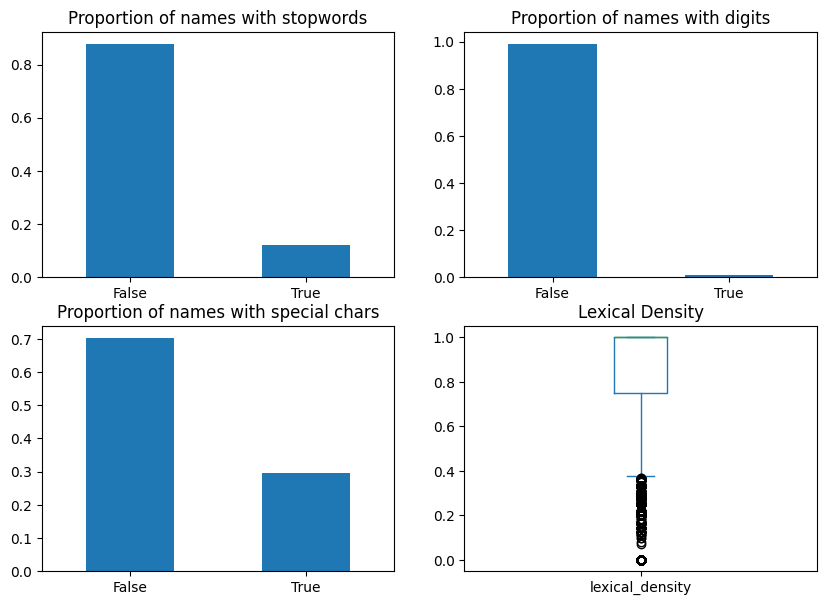

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
ax = corpus_df["has_stopwords"].value_counts(normalize=True).plot(kind="bar", ax=axes[0, 0], rot=0, title="Proportion of names with stopwords")
ax = corpus_df["has_digits"].value_counts(normalize=True).plot(kind="bar", ax=axes[0, 1], rot=0, title="Proportion of names with digits")
ax = corpus_df["has_special_chars"].value_counts(normalize=True).plot(kind="bar", ax=axes[1, 0], rot=0, title="Proportion of names with special chars")
ax = corpus_df["lexical_density"].plot(kind="box", ax=axes[1, 1], title="Lexical Density")

* The distribution of lexical density values seems heavily skewed towards 1.0, which seems reasonable if we consider that most business names have between 1-3 words, most of them usually nouns.
* Only a small portion of business names have stopwords, digits, or special characters on them. Let's explore this in more depth...

In [19]:
sw_idx = corpus_df.query("has_stopwords == True").index.tolist()
digits_idx = corpus_df.query("has_digits == True").index.tolist()
special_char_idx = corpus_df.query("has_special_chars == True").index.tolist()

In [20]:
sw_names = feat_eng_df.loc[sw_idx]
digits_names = feat_eng_df.loc[digits_idx]
special_char_names = feat_eng_df.loc[special_char_idx]

In [21]:
sw_countries = set(sw_names["country"].value_counts()[:10].index.tolist()) & set(feat_eng_df["country"].value_counts()[:10].index.tolist())
sw_proportions = {}
for country_name in sw_countries:
    sw_proportions[country_name] = len(sw_names.query("country == @country_name")) / len(feat_eng_df.query("country == @country_name"))

<AxesSubplot:title={'center':'Top Countries with Stopwords in their Business Names'}>

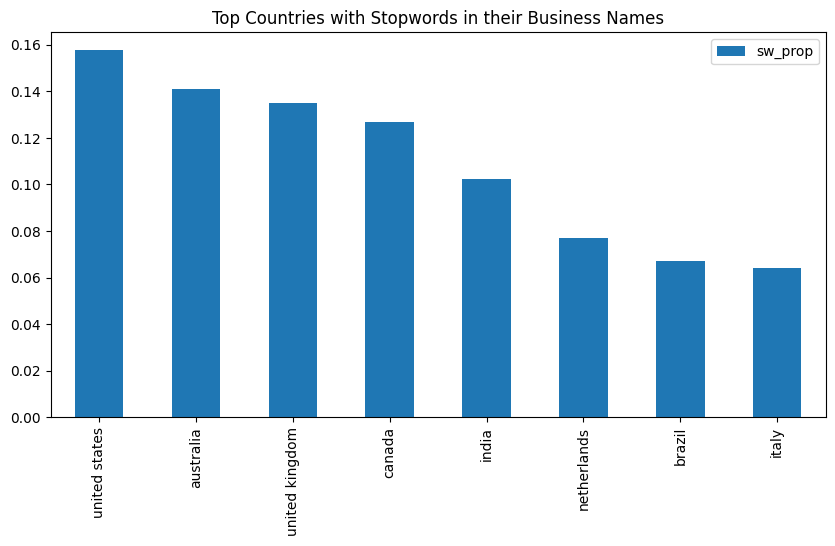

In [22]:
pd.DataFrame.from_dict(
    sw_proportions, 
    columns=["sw_prop"], 
    orient="index"
).sort_values(
    by=["sw_prop"], 
    ascending=False
).plot(
    kind="bar", 
    figsize=(10, 5),
    title="Top Countries with Stopwords in their Business Names"
)

* United States, Australia, United Kingdom, Canada, and India are the top 5 countries with the highest proportion of stopwords in their business names.

## Business names language distribution

<AxesSubplot:title={'center':'Top 15 Languages of Business Names'}>

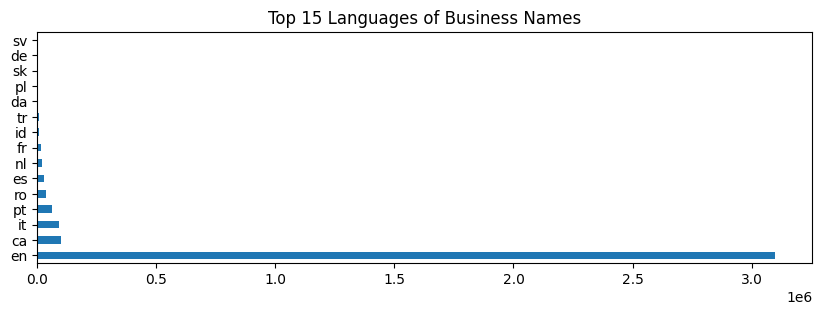

In [23]:
feat_eng_df["lang"].value_counts()[:15].plot(
    kind="barh", 
    figsize=(10, 3),
    title="Top 15 Languages of Business Names",
)

* About 3 million businesses have their names registered in English, followed by 99k in Catalan, 90k in Italian, 63k in Portuguese and 34k in Romanian.
* Distribution seems to be consistent with country distribution, in which the US, UK, and Canada alone accounted for over 41% of all businesses.
* However, language detection might not have worked as accurately for nonenglish names, since Portuguese appears to hold a high value despite neither Brazil nor Portugal showing up in the top 10 within the country distribution (see Pandas Profiling above). 

## Business names and geography

<AxesSubplot:title={'center':'Top 50 cities associated with business names'}>

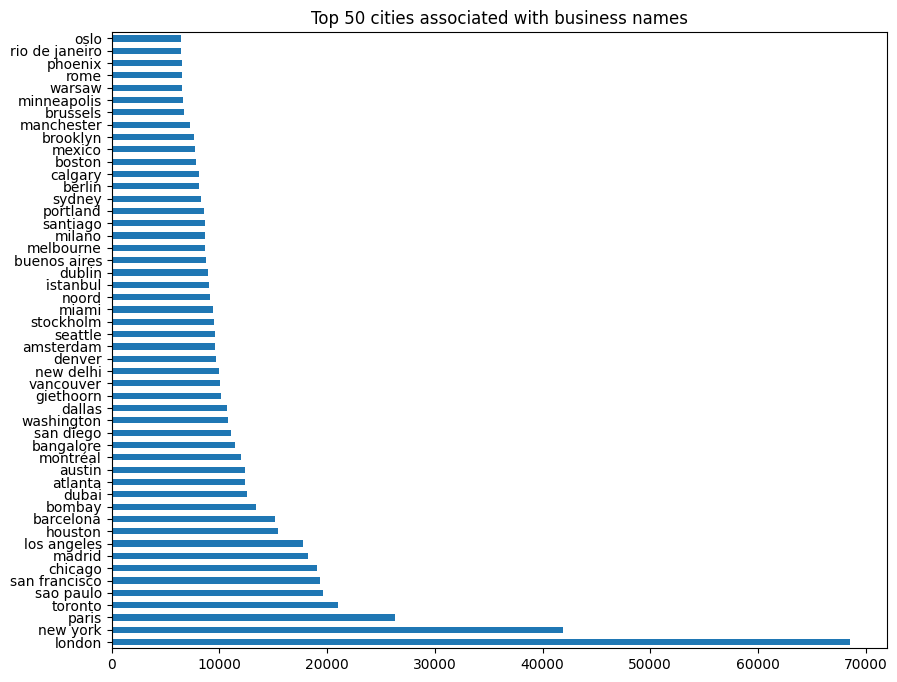

In [24]:
feat_eng_df["city"].value_counts(sort=True)[:50].plot(
    kind="barh",
    title="Top 50 cities associated with business names",
    figsize=(10, 8)
)

* London is the city mostly associated with business names with over 68k records, followed by New York (41k), Paris (26k), Toronto (20k) and Sao Paulo (19k).

## Change of business names over time (case: London)

In [25]:
london_1850_1900 = feat_eng_df.query("city == 'london' and 1850 <= `year founded` < 1900")
london_1900_1950 = feat_eng_df.query("city == 'london' and 1900 <= `year founded` < 1950")
london_1950_2000 = feat_eng_df.query("city == 'london' and 1950 <= `year founded` < 2000")
london_2000_2010 = feat_eng_df.query("city == 'london' and 2000 <= `year founded` < 2010")
london_2010_2022 = feat_eng_df.query("city == 'london' and 2010 <= `year founded` <= 2022")

In [26]:
def word_count(df):
    return [len(name.split()) for name in df["name"]]

words_1850_1900 = pd.DataFrame(word_count(london_1850_1900), columns=["1850-1900"])
words_1900_1950 = pd.DataFrame(word_count(london_1900_1950), columns=["1900-1950"])
words_1950_2000 = pd.DataFrame(word_count(london_1950_2000), columns=["1950-2000"])
words_2000_2010 = pd.DataFrame(word_count(london_2000_2010), columns=["2000-2010"])
words_2010_2022 = pd.DataFrame(word_count(london_2010_2022), columns=["2010-2022"])

Text(0.5, 1.0, 'Density Estimations of Word Frequencies per Epoch')

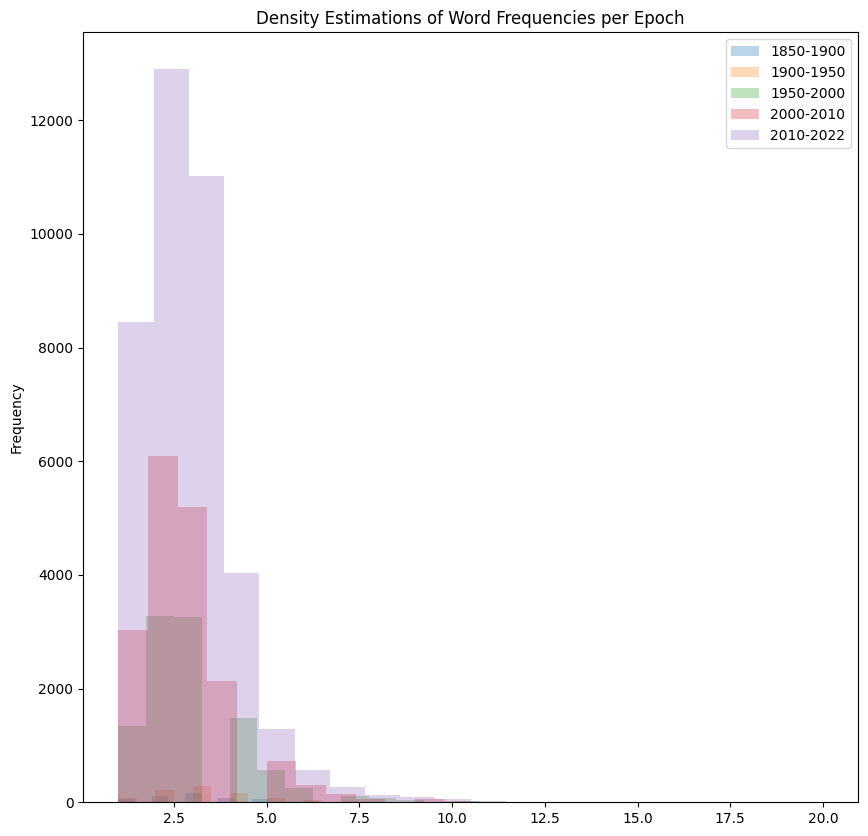

In [27]:
ax = words_1850_1900.plot.hist(bins=20, alpha=0.3, figsize=(10, 10))
words_1900_1950.plot.hist(bins=20, alpha=0.3, figsize=(10, 10), ax=ax)
words_1950_2000.plot.hist(bins=20, alpha=0.3, figsize=(10, 10), ax=ax)
words_2000_2010.plot.hist(bins=20, alpha=0.3, figsize=(10, 10), ax=ax)
words_2010_2022.plot.hist(bins=20, alpha=0.3, figsize=(10, 10), ax=ax)
ax.set_title("Density Estimations of Word Frequencies per Epoch")

In [28]:
print(f"1850-1900 mean count: {round(words_1850_1900.mean()[0], 3)}")
print(f"1900-1950 mean count: {round(words_1900_1950.mean()[0], 3)}")
print(f"1950-2000 mean count: {round(words_1950_2000.mean()[0], 3)}")
print(f"2000-2010 mean count: {round(words_2000_2010.mean()[0], 3)}")
print(f"2010-2022 mean count: {round(words_2010_2022.mean()[0], 3)}")

1850-1900 mean count: 3.363
1900-1950 mean count: 3.25
1950-2000 mean count: 2.88
2000-2010 mean count: 2.668
2010-2022 mean count: 2.529


* As we can see, mean word count seems to decrease as the epochs move closer to today's time. But are these differences statistically significant? Let's find out by running a One-way ANOVA test against the five different groups:

In [29]:
from scipy.stats import f_oneway

stat, p = f_oneway(
    words_1850_1900,
    words_1900_1950,
    words_1950_2000,
    words_2000_2010,
    words_2010_2022
)

print("One-way ANOVA test:")
print(f"stat: {stat[0]:.3f}, p: {p[0]:.6f}")
if p[0] < 0.05:
    print("Differences in mean counts are statistically significant")
else:
    print("Differences in mean counts are not statistically significant")

One-way ANOVA test:
stat: 219.408, p: 0.000000
Differences in mean counts are statistically significant


## Semantic similarity among business names

In [30]:
dist_X = pd.DataFrame(cosine_similarity(vectors_b1), index=vectors_b1.index, columns=vectors_b1.index)

In [31]:
dist_X.head()

,5370658,5062632,4503786,6611753,6150185,5802174,1885071,974438,2179698,2455751,...,6910758,5979380,4151803,1122009,2738665,6513891,1439549,3903780,6427932,3513407
5370658,1.000000,0.905391,0.908962,0.955715,0.871269,0.946645,0.907852,0.972632,0.911110,0.885415,...,0.909082,0.931089,0.918608,0.881715,0.977440,0.945798,0.951162,0.919944,0.882269,0.846190
5062632,0.905391,1.000000,0.864528,0.931526,0.939843,0.964149,0.940350,0.934008,0.937504,0.930646,...,0.849222,0.972200,0.968311,0.839461,0.952058,0.947999,0.897963,0.928989,0.892190,0.920222
4503786,0.908962,0.864528,1.000000,0.912457,0.863659,0.902751,0.885398,0.916249,0.897622,0.860514,...,0.873748,0.886704,0.858199,0.849569,0.899643,0.885210,0.926510,0.879795,0.863295,0.828907
6611753,0.955715,0.931526,0.912457,1.000000,0.904756,0.974895,0.921283,0.963127,0.931087,0.884936,...,0.897167,0.947138,0.923051,0.866144,0.969683,0.932205,0.956160,0.914143,0.882306,0.865297
6150185,0.871269,0.939843,0.863659,0.904756,1.000000,0.936220,0.930501,0.914962,0.939699,0.944126,...,0.822548,0.942366,0.927770,0.805073,0.925315,0.906577,0.877232,0.914568,0.867370,0.947666


In [32]:
dist_X_stats = dist_X.describe()

In [33]:
dist_X_stats

,5370658,5062632,4503786,6611753,6150185,5802174,1885071,974438,2179698,2455751,...,6910758,5979380,4151803,1122009,2738665,6513891,1439549,3903780,6427932,3513407
count,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,...,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000,13958.000000
mean,0.912693,0.926600,0.876875,0.916873,0.902457,0.935740,0.921766,0.927127,0.919880,0.903713,...,0.872051,0.936183,0.929767,0.860495,0.932561,0.931559,0.904124,0.915712,0.890985,0.877235
std,0.042425,0.050791,0.030484,0.042593,0.052073,0.044825,0.041827,0.041656,0.039862,0.051170,...,0.036219,0.048995,0.051613,0.033219,0.046634,0.040695,0.035788,0.042262,0.026049,0.053742
min,0.577962,0.565044,0.596648,0.610085,0.544119,0.628418,0.615546,0.593895,0.641331,0.538846,...,0.620535,0.600089,0.562367,0.647992,0.613936,0.597656,0.595613,0.594786,0.623036,0.522950
25%,0.894748,0.915632,0.858051,0.898078,0.891804,0.922319,0.916895,0.913164,0.911189,0.897579,...,0.853701,0.925917,0.917737,0.845156,0.919201,0.923026,0.884462,0.914648,0.879504,0.865488
50%,0.921778,0.943856,0.880018,0.925310,0.919207,0.949452,0.934985,0.938541,0.932525,0.920050,...,0.875531,0.951807,0.945850,0.862985,0.947106,0.945376,0.908979,0.929573,0.890253,0.892975
75%,0.939217,0.959861,0.900476,0.948174,0.934128,0.965541,0.946692,0.954008,0.944797,0.932496,...,0.894244,0.968104,0.963364,0.878587,0.962873,0.956504,0.931773,0.938244,0.900525,0.908173
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.999999,1.000000,1.000001


<AxesSubplot:title={'center':'Mean pairwise cosine similarities'}, ylabel='Frequency'>

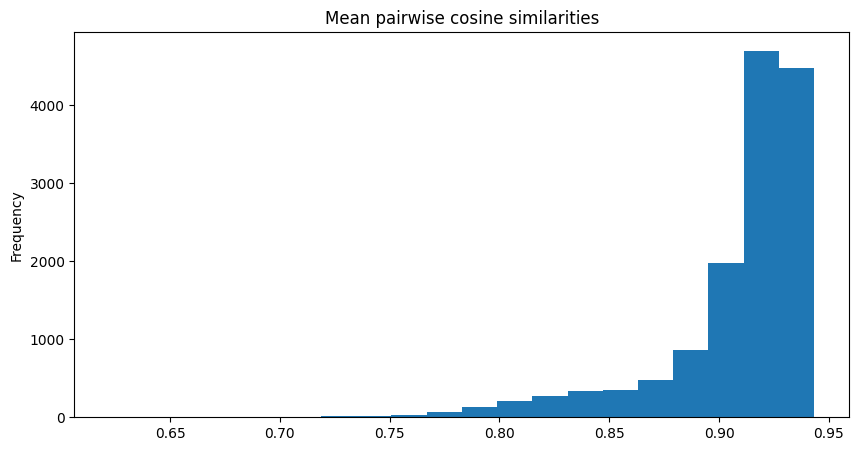

In [34]:
dist_X_stats.loc["mean"].plot.hist(
    bins=20,
    figsize=(10, 5),
    title="Mean pairwise cosine similarities"
)

* The distribution of mean pairwise cosine similarities skews heavily towards high values, awhich seems quite strange at a first glance.
* This behavior might occur since BERT vectors are contextually dependent and business names often oscillate between 1-3 words, which limits the model's ability to learn patterns that rely on relative word/token positions when computing positional encodings.
* Hence, the shortest the input sequence, the higher the similarity values might be between them. Let's explore this further:

In [35]:
# Highest an lowest 20 business names as ranked by similarity values
dist_X_mat = dist_X.to_numpy()
similar_ex = np.argsort(dist_X_mat[0])[::-1]
idx_list = dist_X.iloc[0].index.tolist()
print(f"Name: {feat_eng_df.loc[5370658]['linkedin url']}")
for n, i in enumerate(similar_ex):
    if 0 <= n < 20:
        data = feat_eng_df.loc[idx_list[i]]
        print(f"Cos: {dist_X_mat[0][i]}, Name: {data['name']}, Country: {data['country']}")
    elif n == 20:
        print(f"{'='*100}")
    elif len(similar_ex) - 20 <= n <= len(similar_ex):
        data = feat_eng_df.loc[idx_list[i]]
        print(f"Cos: {dist_X_mat[0][i]}, Name: {data['name']}, Country: {data['country']}")
    else:
        continue

Name: lillycover
Cos: 1.0000004768371582, Name: lillycover, Country: nan
Cos: 0.9894354939460754, Name: rescanm, Country: brazil
Cos: 0.98931884765625, Name: blackpier, Country: spain
Cos: 0.9865334630012512, Name: audaxco, Country: nan
Cos: 0.9864586591720581, Name: dutchlabelcollection, Country: netherlands
Cos: 0.986109733581543, Name: godrive, Country: denmark
Cos: 0.9857556223869324, Name: stylecabin, Country: nan
Cos: 0.9855986833572388, Name: mubler, Country: nan
Cos: 0.9854859709739685, Name: medacheck, Country: united states
Cos: 0.9853688478469849, Name: lumipallo, Country: nan
Cos: 0.9853312373161316, Name: glipub, Country: mexico
Cos: 0.9851915836334229, Name: merrimack, Country: united states
Cos: 0.9850614070892334, Name: coherco, Country: nan
Cos: 0.9846667647361755, Name: optimuslab, Country: nan
Cos: 0.9846358299255371, Name: billsave, Country: ireland
Cos: 0.9845167398452759, Name: loymark, Country: nan
Cos: 0.9844861030578613, Name: shirtech, Country: nan
Cos: 0.9844

* The vector of the business name `lillycover` does seem to hold high similarity values against other one-word business name vectors. Conversely, vectors with longer words/tokens seem to deviate significantly from it.
* But beyond this, cosine similarities don't seem to be driving us to gather more meaningful insights.

# 4. Summary of EDA analysis

* Business naming tends to include patterns such as words associated with legal structure (e.g., pvt. ltd, group, corporation) words that reference the type of business it is (e.g., spa, photography, agency), or words that conform to a particular lexical structure (e.g., X and Y, X & Y).
* Businesses of sizes between 201 and 1000 employees tend to include more legal structure acronyms or words than business smaller or larger in size.
* The distribution of lexical density values seems heavily skewed towards 1.0, which seems reasonable if we consider that most business names have between 1-3 words, most of them usually nouns.
* United States, Australia, United Kingdom, Canada, and India are the top 5 countries with the highest proportion of stopwords in their business names.
* London is the city mostly associated with business names with over 68k records, followed by New York (41k), Paris (26k), Toronto (20k) and Sao Paulo (19k).
* Taking London business names as our sample, we found that the average words of a given business name tends to decrease over time.
* Using cosine similarity with BERT vectors, we found that one-word business names tend to be closer to each other in the semantic space than business names with more words, regardless of language.